# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
%pip install --user labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations split-folders imutils scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Harry Parker\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import time
import uuid
import cv2

### 1.2 Annotate images

In [3]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
datapath=('data\\footage\\*.jpg')
outputmodel = ('./model')
outpulabelbinerizer = ('./labelbinerizer')

face_labels = set(["face"])
print("lmages is being loaded")
pathToImages = list(paths.list_images(datapath))
data = []
labels = []
for images in pathToImages:
    label = images.split(os.path.sep)[-2]
    if label not in face_labels:
        continue
    image = cv2.imread(images)
    data.append(image)
    labels.append(label)


lmages is being loaded


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import Tensorflow and Dependences

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\footage\\*.jpg')

In [8]:
images.as_numpy_iterator().next()

b'data\\footage\\100144.jpg'

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[ 40,  40,  40],
        [ 43,  43,  43],
        [ 38,  38,  38],
        ...,
        [ 76,  76,  76],
        [ 63,  63,  63],
        [ 55,  55,  55]],

       [[ 42,  42,  42],
        [ 47,  47,  47],
        [ 47,  47,  47],
        ...,
        [ 98,  98,  98],
        [ 83,  83,  83],
        [ 74,  74,  74]],

       [[ 32,  32,  32],
        [ 43,  43,  43],
        [ 56,  56,  56],
        ...,
        [111, 111, 111],
        [ 93,  93,  93],
        [ 81,  81,  81]],

       ...,

       [[ 64,  64,  64],
        [ 72,  72,  72],
        [ 84,  84,  84],
        ...,
        [ 78,  78,  78],
        [ 68,  68,  68],
        [ 61,  61,  61]],

       [[ 40,  40,  40],
        [ 47,  47,  47],
        [ 59,  59,  59],
        ...,
        [ 53,  53,  53],
        [ 44,  44,  44],
        [ 39,  39,  39]],

       [[ 22,  22,  22],
        [ 29,  29,  29],
        [ 40,  40,  40],
        ...,
        [ 36,  36,  36],
        [ 27,  27,  27],
        [ 22,  22,  22]]

In [12]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [13]:
image_generator = images.batch(4).as_numpy_iterator()

In [14]:
plot_images = image_generator.next()

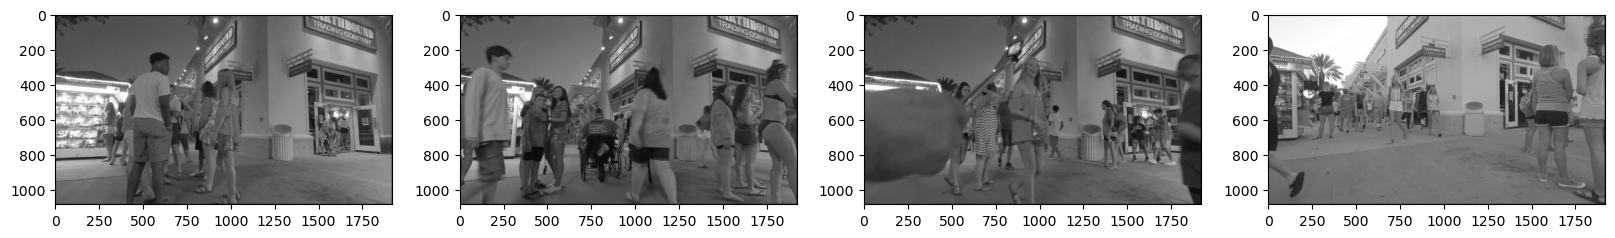

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unargumented Data

### 3.1 Split data into training and testing and valid data

In [16]:
import splitfolders
splitfolders.ratio('./data/img', output="./data/ttvimg", seed=1337, ratio=(.8, 0.1,0.1))

KeyboardInterrupt: 

### Move the Matching Labels

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

### 4.1 Setup Albumentations Transform Pipeline

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=1800, height=1060), alb.RandomBrightnessContrast(p=0.2)], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [19]:
testImage = cv2.imread(os.path.join('data','test','images','10165.jpg'))

In [20]:
testImage

array([[[ 56,  56,  56],
        [ 72,  72,  72],
        [ 85,  85,  85],
        ...,
        [110, 110, 110],
        [ 91,  91,  91],
        [ 70,  70,  70]],

       [[ 83,  83,  83],
        [102, 102, 102],
        [117, 117, 117],
        ...,
        [158, 158, 158],
        [131, 131, 131],
        [105, 105, 105]],

       [[ 96,  96,  96],
        [117, 117, 117],
        [136, 136, 136],
        ...,
        [189, 189, 189],
        [154, 154, 154],
        [122, 122, 122]],

       ...,

       [[ 43,  43,  43],
        [ 52,  52,  52],
        [ 65,  65,  65],
        ...,
        [ 56,  56,  56],
        [ 47,  47,  47],
        [ 42,  42,  42]],

       [[ 25,  25,  25],
        [ 34,  34,  34],
        [ 46,  46,  46],
        ...,
        [ 37,  37,  37],
        [ 30,  30,  30],
        [ 25,  25,  25]],

       [[ 13,  13,  13],
        [ 22,  22,  22],
        [ 33,  33,  33],
        ...,
        [ 30,  30,  30],
        [ 23,  23,  23],
        [ 19,  19,  19]]

In [21]:
with open(os.path.join('data','test','labels','10165.json'), 'r') as f:
    label = json.load(f)

In [22]:
label

{'version': '5.0.5',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[1009.5689655172413, 365.00000000000006],
    [1082.844827586207, 453.7931034482759]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'face',
   'points': [[439.74137931034534, 262.2413793103445],
    [531.1206896551732, 361.5517241379309]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'face',
   'points': [[874.2241379310343, 356.3793103448276],
    [939.7413793103449, 425.3448275862069]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}},
  {'label': 'face',
   'points': [[523.3620689655172, 201.2068965517241],
    [651.8103448275862, 345.1724137931034]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\footage\\10165.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIy

In [23]:
label['shapes'][0]['points']

[[1009.5689655172413, 365.00000000000006],
 [1082.844827586207, 453.7931034482759]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [24]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[1009.5689655172413, 365.00000000000006, 1082.844827586207, 453.7931034482759]

In [26]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [79]:
coords

[0.5258171695402298,
 0.337962962962963,
 0.5639816810344828,
 0.42017879948914433]

### 4.4 Apply Augmentations and View Results

In [27]:
augmented = augmentor(image=testImage, bboxes=[coords], class_labels=['face'])

In [28]:
augmented['bboxes']

[(0.5408716475095785,
  0.3424528301886793,
  0.581580459770115,
  0.4262199089134678)]

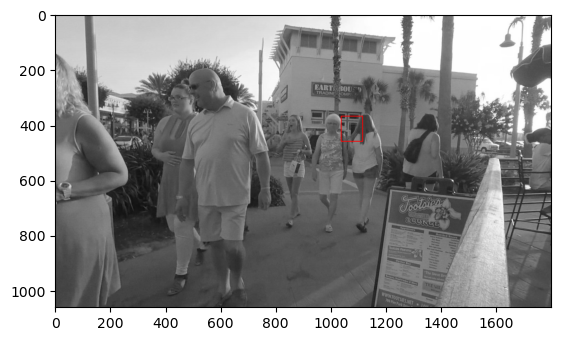

In [29]:
cv2.rectangle(augmented['image'], 
            tuple(np.multiply(augmented['bboxes'][0][:2], [1920,1080]).astype(int)), 
            tuple(np.multiply(augmented['bboxes'][0][2:], [1920,1080]).astype(int)), (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [30]:
for partition in ['test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.000001, 0.000001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['label'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['label'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['label'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        
        except Exception as e:
            print(e)

Expected x_min for bbox [-0.0002424568965517478, 0.000574712643678489, 0.16123383620689652, 0.28927203065134105, 'face'] to be in the range [0.0, 1.0], got -0.0002424568965517478.
x_max is less than or equal to x_min for bbox [0.1922144396551724, 0.013888888888888873, 0.05347521551724134, 0.23898467432950193, 'face'].
x_max is less than or equal to x_min for bbox [0.19401041666666663, 0.28767560664112385, 0.12890624999999997, 0.3890485312899106, 'face'].
x_max is less than or equal to x_min for bbox [0.23666487068965517, 0.29086845466155814, 0.18098958333333331, 0.3682950191570881, 'face'].
x_max is less than or equal to x_min for bbox [0.49214260057471265, 0.47525542784163477, 0.47103987068965514, 0.43295019157088127, 'face'].
x_max is less than or equal to x_min for bbox [0.3430765086206896, 0.2780970625798212, 0.21006952447907062, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.3754040948275862, 0.3052362707535122, 0.24519576149425285, 0.02187100893997444, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# 5. Prepare Labels

### 5.1 Build Label Loading Function

In [23]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 5.2 Load Labels to Tensorflow Dataset

In [24]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data\\train\\labels\\*.json'

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

# 6. Combine Labels and Image Samples

### 6.1 Check Partition Length

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

### 6.2 Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

### 6.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 7 Build Deep Learning Model using the Functional API

### 7.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 7.2 Download VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

### 7.3 Build Instance of Network

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 7.4 Test out Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

# 8 Define Losses and Optimisers

### 8.1 Define Optimiser and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 8.2 Create Localisation Loss and Classification Loss

In [ ]:
def localisation_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localisation_loss

### 7.3 Test out Loss Metrics

In [ ]:
localisation_loss(y[1], coords)

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

# 8 Train Neural Network

### .1 Create Custom Model Class

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, classloss, localisation_loss, opt, **kwargs):
        super().compile(**kwargs)
        self.clsloss = classloss
        self.localloss = localisation_loss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_class_loss = self.clsloss(y[0], classes)
            batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)

            total_loss = (0.5*batch_class_loss) + batch_localisation_loss

            gradient = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(gradient, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_class_loss = self.clsloss(y[0], classes)
        batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)
        total_loss = (0.5*batch_class_loss) + batch_localisation_loss

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(classloss, localisation_loss, opt)

### 9.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

### 9.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 10. Make Predictions

### 10.1 Make Predictions 

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 10.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker.load_model('facetracker.h5')